In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

font = {'family': 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

from pathlib import Path
from extract_metrics import extract_data_to_dataframe

In [2]:
data_root = 'data/results/aggreg'
data_fields = ['read_time_total_mean','read_accesses_total_mean']

algorithm = 'fifo'

heading_order = ['workflow_size', 'sched_alg_sys_conf', 'cores', 'read_time_total_avg']
cores_order = ['8', '16', '24']
workflow_size_order = [58, 103, 178, 310, 472, 619]
workflows_group = 'C'

file_names = ['1_SL_1.csv', '1_MA_1.csv']
base_sched_alg_sys_conf = 'SL'
test_sched_alg_sys_conf = 'MA'

workflows = {
    f'{workflows_group}_montage-chameleon-2mass-025d-001': 619,
    f'{workflows_group}_montage-chameleon-dss-10d-001': 472,
    f'{workflows_group}_montage-chameleon-2mass-015d-001': 310,
    f'{workflows_group}_montage-chameleon-dss-075d-001': 178,
    f'{workflows_group}_montage-chameleon-2mass-01d-001': 103,
    f'{workflows_group}_montage-chameleon-dss-05d-001': 58,   
}

output_file_name = f'read_time_avg_diff_{base_sched_alg_sys_conf}-{test_sched_alg_sys_conf}_{workflows_group}.pdf'

dfs = [ extract_data_to_dataframe(Path(f'{data_root}/{k}'), data_fields).assign(workflow_size=v) for k, v in workflows.items() ]
df = pd.concat(dfs, ignore_index=True)

# Filter rows where 'file_name' matches one of the selected names 
# and 'folder' contains the specified algorithm substring
df_cond = (df["file_name"].isin(file_names)) & (df["folder"].str.contains(algorithm))
df = df[df_cond].copy()

df = df.rename(columns={'folder': 'cores', 'file_name': 'sched_alg_sys_conf'})
df['cores'] = df['cores'].map(lambda x : x.split('_')[1])
df['sched_alg_sys_conf'] = df['sched_alg_sys_conf'].map(lambda x : x.split('_')[1])

# Compute average read time.
df['read_time_total_avg'] = df['read_time_total_mean'] / df['read_accesses_total_mean']
df = df[heading_order]
df

,workflow_size,sched_alg_sys_conf,cores,read_time_total_avg
0,619,MA,16,0.083439
2,619,SL,16,0.072075
4,619,MA,24,0.083782
6,619,SL,24,0.072087
8,619,MA,8,0.085934
10,619,SL,8,0.071991
36,472,MA,16,0.084153
38,472,SL,16,0.072330
40,472,MA,24,0.083235
42,472,SL,24,0.072258


In [3]:
# Assuming your DataFrame is named df
# Pivot the DataFrame to get sched_alg_sys_conf values as columns
pivot_df = df.pivot(index=['workflow_size', 'cores'], columns='sched_alg_sys_conf', values='read_time_total_avg')
pivot_df

sched_alg_sys_conf         MA        SL
workflow_size cores                    
58            16     0.073283  0.072583
              24     0.079222  0.072613
              8      0.080398  0.072256
103           16     0.078796  0.072495
              24     0.080003  0.072678
              8      0.085995  0.072003
178           16     0.083877  0.072380
              24     0.083000  0.072542
              8      0.084164  0.072009
310           16     0.084976  0.072468
              24     0.083475  0.072734
              8      0.084941  0.072124
472           16     0.084153  0.072330
              24     0.083235  0.072258
              8      0.084844  0.072068
619           16     0.083439  0.072075
              24     0.083782  0.072087
              8      0.085934  0.071991

In [4]:
# Create a new column with the difference
pivot_df['diff_abs'] = abs(pivot_df[base_sched_alg_sys_conf] - pivot_df[test_sched_alg_sys_conf])

# Optional: reset index if you want a flat DataFrame
result = pivot_df.reset_index()
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   workflow_size  18 non-null     int64  
 1   cores          18 non-null     object 
 2   MA             18 non-null     float64
 3   SL             18 non-null     float64
 4   diff_abs       18 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 852.0+ bytes


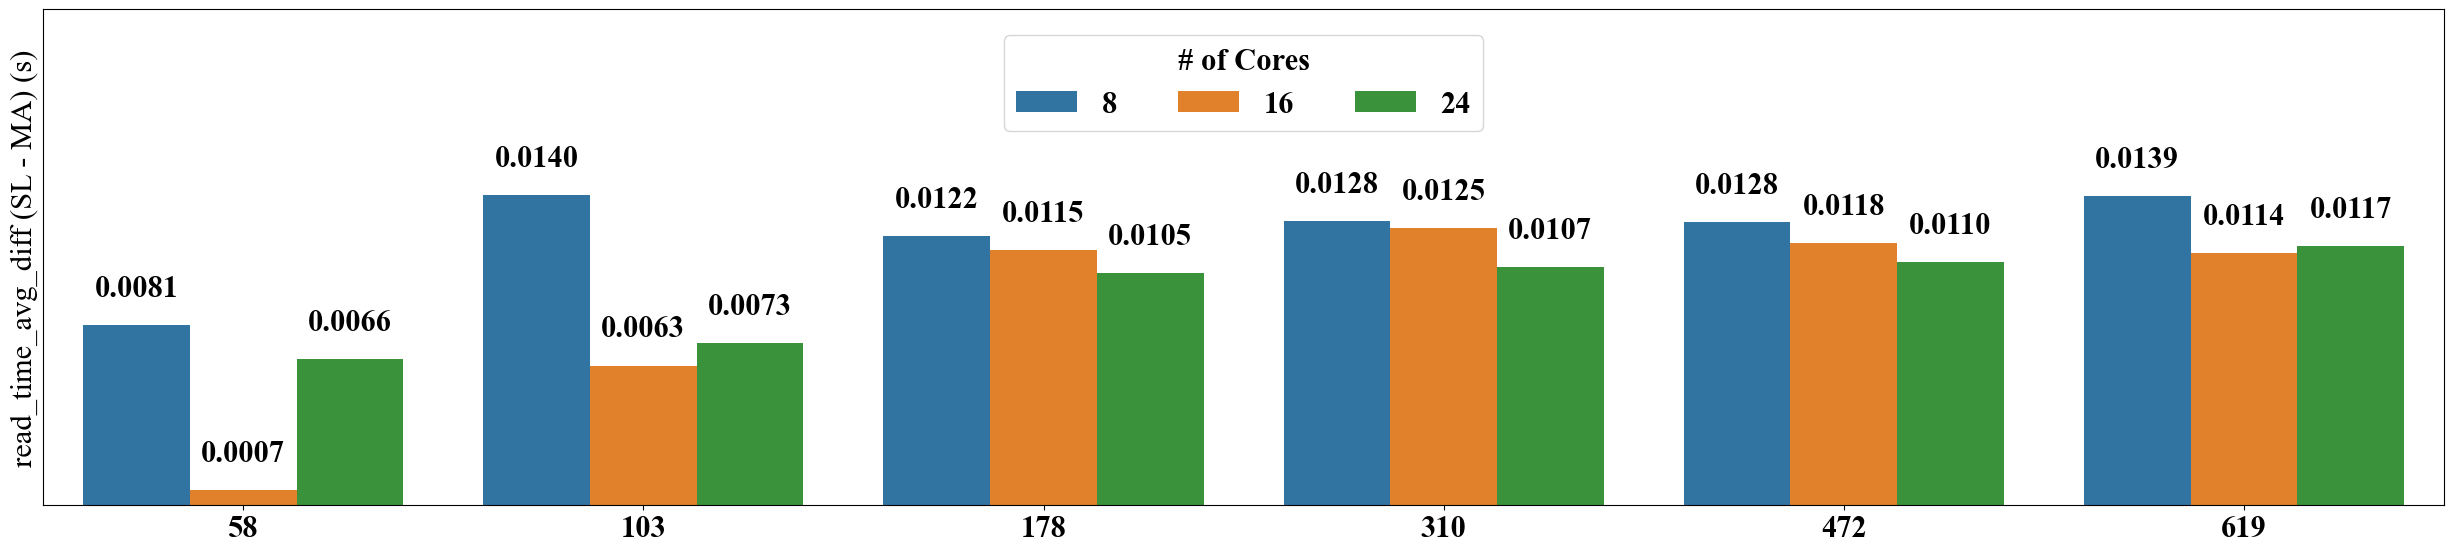

In [5]:
plt.figure(figsize=(25, 6))

ax = sns.barplot(
    data=result, x='workflow_size', y='diff_abs', hue='cores', 
    order=workflow_size_order, hue_order=cores_order
)
ax.set_yticks([])

plt.ylabel("read_time_avg_diff (SL - MA) (s)")
plt.xlabel("")

plt.margins(y=0.6)
plt.tight_layout()

# Add labels above or below bars
for bar in ax.patches:
    value = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    offset = 0.001 * (1 if value >= 0 else -1)
    va = 'bottom' if value >= 0 else 'top'
    ax.text(x, value + offset, f"{value:.4f}", ha='center', va=va)

# Place the legend at the top and horizontally
plt.legend(title='# of Cores', bbox_to_anchor=(0.5, 0.85), loc='center', ncol=9)
plt.savefig(output_file_name, dpi=300, bbox_inches='tight')